In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a list of stocks
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NFLX", "NVDA", "JPM", "BAC"]

# Download historical data
data = yf.download(tickers, start="2023-01-01", end="2023-12-31")['Close']
returns = data.pct_change().dropna()

# Calculate mean return and volatility for each stock
stock_features = pd.DataFrame({
    'Mean_Return': returns.mean() * 252,  # Annualized mean return
    'Volatility': returns.std() * np.sqrt(252)  # Annualized volatility
})

print(stock_features.head())


[*********************100%***********************]  10 of 10 completed


        Mean_Return  Volatility
Ticker                         
AAPL       0.456737    0.199473
AMZN       0.632897    0.330267
BAC        0.040859    0.269220
GOOGL      0.501408    0.303982
JPM        0.254719    0.208465


/Users/tarundamodaran/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustered Stock Features:
         Mean_Return  Volatility  Cluster
Ticker                                  
AAPL       0.456737    0.199473        1
AMZN       0.632897    0.330267        0
BAC        0.040859    0.269220        0
GOOGL      0.501408    0.303982        0
JPM        0.254719    0.208465        1
META       1.132278    0.398289        2
MSFT       0.487938    0.251326        1
NFLX       0.576452    0.375860        0
NVDA       1.370890    0.484582        2
TSLA       0.980966    0.526488        2


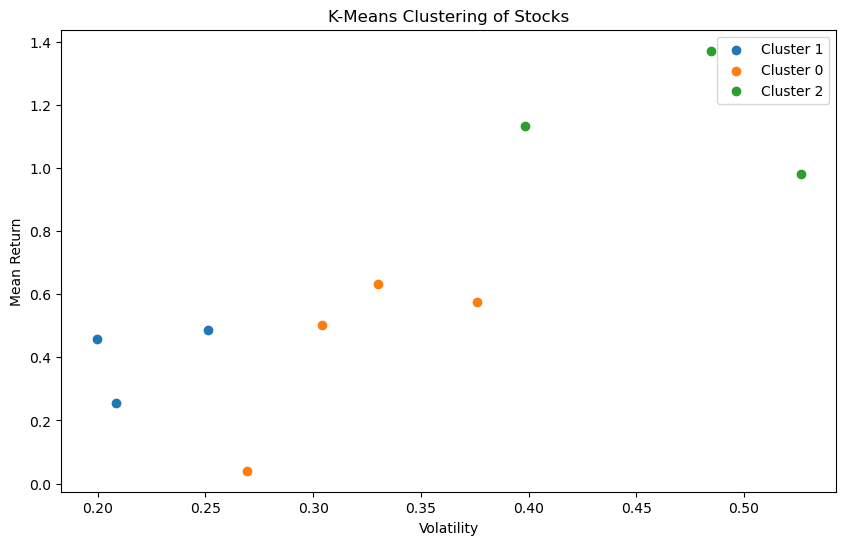

In [4]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(stock_features)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
stock_features['Cluster'] = kmeans.fit_predict(scaled_features)

print("Clustered Stock Features:\n", stock_features)

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in stock_features['Cluster'].unique():
    cluster_data = stock_features[stock_features['Cluster'] == cluster]
    plt.scatter(cluster_data['Volatility'], cluster_data['Mean_Return'], label=f"Cluster {cluster}")

plt.xlabel("Volatility")
plt.ylabel("Mean Return")
plt.title("K-Means Clustering of Stocks")
plt.legend()
plt.show()


In [5]:
from sklearn.decomposition import PCA

# Apply PCA on daily returns
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = stock_features['Cluster'].values

print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.67988161 0.31302582]


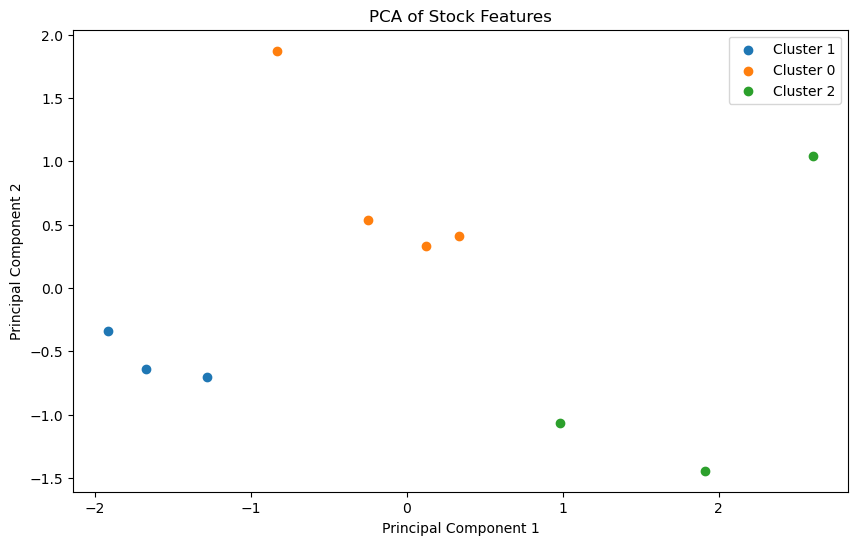

In [6]:
plt.figure(figsize=(10, 6))
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f"Cluster {cluster}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Stock Features")
plt.legend()
plt.show()


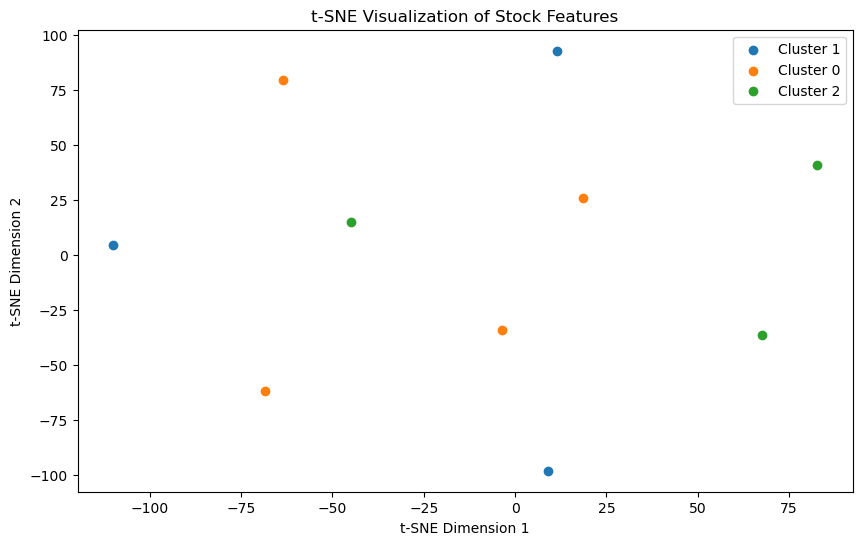

In [8]:
from sklearn.manifold import TSNE

# Check the number of samples
n_samples = scaled_features.shape[0]

# Set perplexity to be less than n_samples, with a maximum of 30
perplexity = min(30, n_samples - 1)

# Apply t-SNE for dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
tsne_results = tsne.fit_transform(scaled_features)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = stock_features['Cluster'].values

plt.figure(figsize=(10, 6))
for cluster in tsne_df['Cluster'].unique():
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f"Cluster {cluster}")

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Stock Features")
plt.legend()
plt.show()

In [9]:
# Select one stock from each cluster for diversification
diversified_portfolio = stock_features.groupby('Cluster').apply(lambda x: x.sample(1))
print("Diversified Portfolio:\n", diversified_portfolio.index)


Diversified Portfolio:
 MultiIndex([(0,  'BAC'),
            (1,  'JPM'),
            (2, 'META')],
           names=['Cluster', 'Ticker'])


In [10]:
# Use distance to cluster center as an anomaly score
distances = kmeans.transform(scaled_features)
stock_features['Anomaly_Score'] = distances.min(axis=1)

# Identify stocks with the highest anomaly scores
anomalies = stock_features.sort_values(by='Anomaly_Score', ascending=False).head()
print("Anomalies:\n", anomalies)


Anomalies:
         Mean_Return  Volatility  Cluster  Anomaly_Score
Ticker                                                 
TSLA       0.980966    0.526488        2       1.712522
BAC        0.040859    0.269220        0       1.279038
META       1.132278    0.398289        2       1.034708
NVDA       1.370890    0.484582        2       0.960355
NFLX       0.576452    0.375860        0       0.670325
